In [88]:
import geopandas as gp
import pandas as pd
import random
import math
import copy
from shapely import STRtree
from shapely.geometry import Point, Polygon
from PIL import ImageFont
from collections import namedtuple

# Demo only
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm

def generate_town_name() -> str:
	a = ["Test", "Trial", "Experiment", "Try", "Placeholder"]
	b = ["town", " City", " Village", "ville", "burg","ton", ""]
	return f"{random.choice(a)}{random.choice(b)}"

def generate_random_points(point_count: int = 20) -> gp.GeoDataFrame:
	gdf = gp.GeoDataFrame(
		data={
			"name": [generate_town_name() for i in range(point_count)],
			"population": [random.randrange(500,50000) for i in range(point_count)],
			"geometry": [Point(random.randrange(0,50),random.randrange(0,50)) for i in range(point_count)]},
		geometry="geometry",
		crs='EPSG:4326'
	)
	return gdf

cities = generate_random_points(30)


<Axes: >

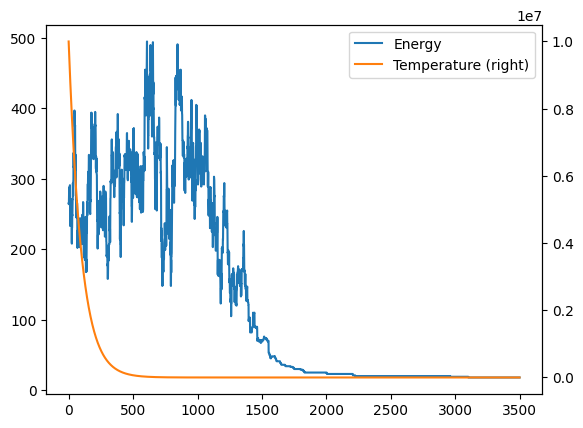

In [89]:
debug_energy = []
debug_temperature = []

LabelPosition = namedtuple("LabelPosition", "x y cost")

label_positions = [
	LabelPosition("top", "right", 0),
	LabelPosition("top", "left", 1),
	LabelPosition("middle", "right", 1),
	LabelPosition("middle", "left", 1),
	LabelPosition("bottom", "right", 1),
	LabelPosition("bottom", "left", 2),
	LabelPosition("top", "center", 3),
	LabelPosition("bottom", "center", 4),
]

label_margin = .5;

def pop_to_font_size(pop: int):
	size = 1.2;
	if (pop > 10000):
		size = 1.5
	if (pop > 45000):
		size = 1.85
	return size

def rect_to_points(bounds):
	x1,y1,x2,y2 = bounds
	return (
		(x1,y1),
		(x2,y1),
		(x2,y2),
		(x1,y2),
		(x1,y1),
	)

def get_label_coords(point, label_text: str, label_pos: int, font_size: float):
	# Given a point, text, and label_position, return [x1,y1,x2,y2]
	x1,y1,x2,y2 = (0,)*4

	label_vertical = label_positions[label_pos].x
	label_horizontal = label_positions[label_pos].y
	
	scale = 10
	atlas = ImageFont.truetype(
		"../fonts/Merriweather/Merriweather-Regular.ttf",
		size=int(font_size*scale)
	)

	bbox = atlas.getbbox(label_text)
	width = atlas.getlength(label_text) / scale
	height = ((bbox[3]) * .9) / scale

	if (label_horizontal == "left"):
		x1 = point[0] - label_margin - width
		x2 = x1 + width		
	if (label_horizontal == "right"):
		x1 = point[0] + label_margin
		x2 = x1 + width
	if (label_horizontal == "center"):
		x1 = point[0] - width / 2
		x2 = x1 + width
	if (label_vertical == "top"):
		y1 = point[1] + label_margin
		y2 = y1 + height
	if (label_vertical == "middle"):
		y1 = point[1] - height / 2
		y2 = y1 + height
	if (label_vertical == "bottom"):
		y1 = point[1] - label_margin - height
		y2 = y1 + height

	return (x1,y1,x2,y2) 

time_limit = 3500;

def get_temperature(t):
	# Given t, return the current temperatue in the annealing schedule (exponential decay)
	return (.99 ** t) * 1e7

def get_neighbour(s):
	# Returns a neighbouring state by moving a single label
	state = copy.deepcopy(s)

	i = random.randrange(0, len(state))
	label_choices = [pos for pos in list(range(len(label_positions))) if pos != state[i]["label_pos"]]
	label_pos = random.choice(label_choices)

	state[i]["label_pos"] = label_pos
	state[i]["label_pos_v"] = label_positions[label_pos].x
	state[i]["label_pos_h"] = label_positions[label_pos].y
	
	state[i]["label_coords"] = get_label_coords(
		state[i]["feature_coords"],
		state[i]["label_text"],
		state[i]["label_pos"],
		state[i]["font_size"])

	return state

def get_energy(state):
	# Compute the energy of a given state
	e = 0;
	geoms = [Polygon(rect_to_points(point["label_coords"])).buffer(1) for point in state]
	tree = STRtree(geoms)

	for i, point in enumerate(state):
		geom = Polygon(rect_to_points(point["label_coords"]))
		lp = label_positions[point["label_pos"]]
		# Label positions cost
		e += lp.cost
		# Overlap cost
		e += len(tree.query(geom, predicate="intersects")) * 10 - 10
	return e

def get_acceptance_prob(e, e_new, temperature):
	if (e_new < e):
		return 1
	else:
		return math.e ** (-1 * (e_new - e) / temperature)

def place_labels(gdf: gp.GeoDataFrame) -> gp.GeoDataFrame:
	
	# Generate random initial state
	state = []
	for i, obj in gdf.iterrows():
		label_text = obj["name"]
		font_size = pop_to_font_size(obj["population"])
		label_pos = random.randrange(len(label_positions))
		feature_coords = (obj.geometry.x, obj.geometry.y)

		state.append({
		"feature_coords": feature_coords,
		"label_text": label_text,
		"font_size": font_size,
		"label_pos": label_pos,
		"label_pos_v": label_positions[label_pos][0],
		"label_pos_h": label_positions[label_pos][1],
		"label_coords": get_label_coords(
			feature_coords,
			label_text,
			label_pos,
			font_size
		)})
	t = 0

	# Anneal
	while t < time_limit:
		temperature = get_temperature(t)
		state_new = get_neighbour(state)
		e = get_energy(state)
		e_new = get_energy(state_new)
		if (get_acceptance_prob(e, e_new, temperature) > random.uniform(0,1)):
			state = state_new
		debug_energy.append(e)
		debug_temperature.append(temperature)
		t += 1;
	
	# Cull overlapping labels

	return state


labels = place_labels(cities)

axd = pd.DataFrame(debug_energy, columns=["Energy"]).plot()
pd.DataFrame(debug_temperature, columns=["Temperature"]).plot(ax=axd, secondary_y=True)

[600. 600.]


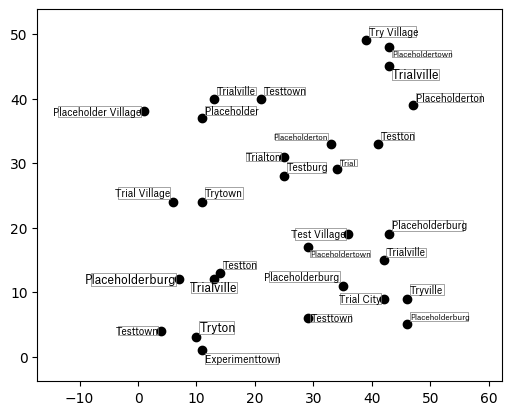

In [99]:
label_boxes = gp.GeoDataFrame(
	data={
		"font_size": [l["font_size"] for l in labels],
		"label_text": [l["label_text"] for l in labels],
		"label_ha": [l["label_pos_h"] for l in labels],
		"geometry": [Polygon(rect_to_points(l["label_coords"])) for l in labels]},
	geometry="geometry",
	crs='EPSG:4326'
)

atlas_regular = fm.FontProperties(fname='../fonts/Atlas Grotesk Regular.ttf')

fig, ax = plt.subplots(figsize=(6, 6))
cities.plot(ax=ax, color="black")
label_boxes.plot(ax=ax, color="none", edgecolor="gray", lw=.5)

size = fig.get_size_inches()*fig.dpi
print(size)

for i, l in label_boxes.iterrows():
	x = l.geometry.bounds[0]
	ta = "left"
	if (l.label_ha == "left"):
		x = l.geometry.bounds[2]
		ta = "right"
	if (l.label_ha == "center"):
		x = l.geometry.centroid.x
		ta = "center"
	plt.text(
        x,
        l.geometry.centroid.y,
        f"{l.label_text}",
        fontproperties=atlas_regular,
        fontsize=l.font_size * 4.6,
        horizontalalignment=ta,
        verticalalignment="center"
    )